IMPORT LIBRARY

In [1]:
# import libary yang akan digunakan
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

BUAT VARIABEL

In [2]:
# buat variabel untuk menyimpan fitur, label, gambar, dan jumlah gambar
features = []
labels = []
images = []
category_counts = {}

LOAD DATASET

In [3]:
# load dataset
dataset_path = r"C:\Users\Satria Dharma\OneDrive\Desktop\Belajar Coding\PPDM\Vehicle Type Recognition Menggunakan SVM\Dataset" # dapat diubah sesuai direktori dataset
categories = ["bus", "car", "truck", "motorcycle"]

FUNGSI AUGMENTASI

In [4]:
# fungsi untuk melakukan augmentasi data
def augment_image(img):
    augmented = [img]

    flipped = cv2.flip(img, 1)
    augmented.append(flipped)

    h, w = img.shape[:2]
    M_pos15 = cv2.getRotationMatrix2D((w // 2, h // 2), 15, 1.0)
    rotated_pos15 = cv2.warpAffine(img, M_pos15, (w, h))
    augmented.append(rotated_pos15)

    M_neg15 = cv2.getRotationMatrix2D((w // 2, h // 2), -15, 1.0)
    rotated_neg15 = cv2.warpAffine(img, M_neg15, (w, h))
    augmented.append(rotated_neg15)

    return augmented

NORMALISASI UKURAN GAMBAR

In [5]:
# normalisasi ukuran panjang dan lebar dari gambar
img_height = 128
img_width = 128

FUNGSI EKSTRAKSI FITUR HOG

In [6]:
# fungsi ekstraksi fitur dengan Histogram of Oriented Gradients (HOG)
def hog(img):
    img = cv2.resize(img, (img_width, img_height))
    
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()

    cell_size = 8
    block_size = 2
    nbins = 9
    
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=1)
    
    magnitude = np.sqrt(gx ** 2 + gy ** 2)
    orientation = (np.arctan2(gy, gx) * (180 / np.pi)) % 180

    height, width = gray.shape
    n_cells_y = height // cell_size
    n_cells_x = width // cell_size
    histograms = np.zeros((n_cells_y, n_cells_x, nbins), dtype=np.float32)

    for y in range(height):
        for x in range(width):
            mag = magnitude[y, x]
            angle = orientation[y, x]
            
            cell_x = x // cell_size
            cell_y = y // cell_size
            if cell_x >= n_cells_x or cell_y >= n_cells_y:
                continue

            bin_idx = angle / (180 / nbins)
            bin_lower = int(bin_idx) % nbins
            bin_upper = (bin_lower + 1) % nbins
            weight_upper = bin_idx - bin_lower
            weight_lower = 1 - weight_upper

            histograms[cell_y, cell_x, bin_lower] += mag * weight_lower
            histograms[cell_y, cell_x, bin_upper] += mag * weight_upper

    n_blocks_y = n_cells_y - block_size + 1
    n_blocks_x = n_cells_x - block_size + 1
    eps = 1e-5
    hog_vector = []

    for y in range(n_blocks_y):
        for x in range(n_blocks_x):
            block = histograms[y:y+block_size, x:x+block_size, :].flatten()
            norm = np.sqrt(np.sum(block ** 2) + eps ** 2)
            normalized_block = block / norm
            hog_vector.append(normalized_block)

    return np.concatenate(hog_vector)

FUNGSI EKSTRAKSI FITUR HISTOGRAM WARNA

In [7]:
# fungsi ekstraksi fitur dengan Histogram Warna
def color_histogram(img, bins=(8, 8, 8)):
    img = cv2.resize(img, (img_width, img_height))
    hist = np.zeros(bins[0] * bins[1] * bins[2], dtype=np.float32)
    height, width = img.shape[:2]
    
    bin_width = [256 // bins[i] for i in range(3)]

    for y in range(height):
        for x in range(width):
            b, g, r = img[y, x]
            b_bin = min(b // bin_width[0], bins[0] - 1)
            g_bin = min(g // bin_width[1], bins[1] - 1)
            r_bin = min(r // bin_width[2], bins[2] - 1)

            idx = int(r_bin) * bins[1] * bins[0] + int(g_bin) * bins[0] + int(b_bin)
            hist[idx] += 1.0

    norm = np.sqrt(np.sum(hist ** 2) + 1e-10)
    hist /= norm
    
    return hist

FUNGSI EKSTRAKSI FITUR GLCM

In [8]:
# fungsi graycomatrix untuk ekstraksi fitur Gray-Level Co-occurrence Matrix (GLCM)
def graycomatrix(image, distances, angles, levels, symmetric, normed):
    image = cv2.resize(image, (img_width, img_height))
    height, width = image.shape
    result = np.zeros((levels, levels, len(distances), len(angles)), dtype=np.float64)
    
    if levels != 256:
        image = np.floor(image * (levels / 256)).astype(np.int32)
        image = np.clip(image, 0, levels - 1)

    for d_idx, distance in enumerate(distances):
        for a_idx, angle in enumerate(angles):
            dx, dy = int(round(np.cos(angle) * distance)), int(round(np.sin(angle) * distance))
            
            for y in range(height):
                for x in range(width):
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < height and 0 <= nx < width:
                        i, j = image[y, x], image[ny, nx]
                        result[i, j, d_idx, a_idx] += 1
                        if symmetric:
                            result[j, i, d_idx, a_idx] += 1

    if normed:
        for d_idx in range(len(distances)):
            for a_idx in range(len(angles)):
                total = np.sum(result[:, :, d_idx, a_idx])
                if total > 0:
                    result[:, :, d_idx, a_idx] /= total

    return result

# fungsi graycoprops untuk ekstraksi fitur Gray-Level Co-occurrence Matrix (GLCM)
def graycoprops(matrix, prop):
    num_distances = matrix.shape[2]
    num_angles = matrix.shape[3]
    results = np.zeros((num_distances, num_angles))
    
    I, J = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]), indexing='ij')
    
    for d in range(num_distances):
        for a in range(num_angles):
            P = matrix[:, :, d, a]
            if prop == 'contrast':
                results[d, a] = np.sum(P * ((I - J) ** 2))
            elif prop == 'correlation':
                mu_i = np.sum(I * P)
                mu_j = np.sum(J * P)
                sigma_i = np.sqrt(np.sum(P * ((I - mu_i) ** 2)))
                sigma_j = np.sqrt(np.sum(P * ((J - mu_j) ** 2)))
                results[d, a] = np.sum(P * (I - mu_i) * (J - mu_j) / (sigma_i * sigma_j + 1e-10))
            elif prop == 'energy':
                results[d, a] = np.sum(P ** 2)
            elif prop == 'homogeneity':
                results[d, a] = np.sum(P / (1 + np.abs(I - J)))
    return results

# fungsi ekstraksi fitur dengan Gray-Level Co-occurrence Matrix (GLCM)
def glcm(img):
    img = cv2.resize(img, (img_width, img_height))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    glcm = graycomatrix(
        gray,
        distances=[1],
        angles=[0],
        levels=256,
        symmetric=True,
        normed=True
    )
    
    props = ['contrast', 'correlation', 'energy', 'homogeneity']
    feats = [graycoprops(glcm, p)[0, 0] for p in props]
    return np.array(feats)

AUGMENTASI DAN EKSTRAKSI FITUR

In [9]:
# melakukan ekstraksi fitur dan augmentasi gambar
print("Memulai ekstraksi fitur dan augmentasi gambar...")

for category in categories:
    folder = os.path.join(dataset_path, category)
    count = 0

    for filename in os.listdir(folder):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Gagal membaca gambar {img_path}")
            continue
        img = cv2.resize(img, (128, 128))

        for aug_img in augment_image(img):
            hog_feat = hog(aug_img)
            color_feat = color_histogram(aug_img)
            glcm_feat = glcm(aug_img)
            full_feat = np.hstack([hog_feat, color_feat, glcm_feat])
            features.append(full_feat)
            labels.append(category)
            images.append(aug_img)
            count += 1

    category_counts[category] = count
    print(f"{category.capitalize():<12}: {count} gambar berhasil diproses")

Memulai ekstraksi fitur dan augmentasi gambar...
Bus         : 376 gambar berhasil diproses
Car         : 396 gambar berhasil diproses
Truck       : 356 gambar berhasil diproses
Motorcycle  : 400 gambar berhasil diproses


KELAS LABEL ENCODER

In [10]:
# kelas LabelEncoder yang dibuat tanpa menggunakan library LabelEncoder
class LabelEncoder:

    # fungsi untuk inisialisasi atribut kelas, mapping label ke index, dan mapping index ke label
    def __init__(self):
        self.classes_ = None
        self.class_to_index = {}
        self.index_to_class = {}

    # fungsi untuk menyimpan label unik yang telah diurutkan, serta membuat mapping bagi label dan indez
    def fit(self, labels):
        unique_labels = sorted(set(labels))
        self.classes_ = np.array(unique_labels)
        self.class_to_index = {label: idx for idx, label in enumerate(self.classes_)}
        self.index_to_class = {idx: label for idx, label in enumerate(self.classes_)}

    # fungsi untuk mengubah daftar label menjadi daftar indeks numerik
    def transform(self, labels):
        if self.classes_ is None:
            raise ValueError("Encoder belum di-fit. Panggil 'fit()' atau 'fit_transform()' terlebih dahulu.")
        
        try:
            return np.array([self.class_to_index[label] for label in labels])
        except KeyError as e:
            raise ValueError(f"Label tidak dikenali: {e}")

    # fungsi kombinasi dari fit() dan transform()
    def fit_transform(self, labels):
        self.fit(labels)
        return self.transform(labels)

    # fungsi untuk mengubah kembali daftar indeks numerik menjadi daftar label asli
    def inverse_transform(self, indices):
        if self.classes_ is None:
            raise ValueError("Encoder belum di-fit.")
        
        try:
            return [self.index_to_class[int(idx)] for idx in indices]
        except KeyError as e:
            raise ValueError(f"Indeks tidak dikenali: {e}")

FUNGSI SPLIT DATASET

In [11]:
# fungsi untuk membagi dataset menjadi data train dan data test
def train_test_split(X, y, images=None, test_size=0.2, random_state=None):
    if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
        raise TypeError("X dan y harus berupa numpy array.")
    
    if images is not None and not isinstance(images, np.ndarray):
        raise TypeError("images harus berupa numpy array atau None.")
    
    if len(X) != len(y) or (images is not None and len(X) != len(images)):
        raise ValueError("Panjang X, y, dan images harus sama.")
    
    if not (0 < test_size < 1):
        raise ValueError("test_size harus berupa nilai antara 0 dan 1.")

    if random_state is not None:
        np.random.seed(random_state)
    
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    
    test_count = int(len(X) * test_size)
    test_indices = indices[:test_count]
    train_indices = indices[test_count:]

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    if images is not None:
        img_train, img_test = images[train_indices], images[test_indices]
    else:
        img_train, img_test = None, None

    return X_train, X_test, y_train, y_test, img_train, img_test

UBAH LIST FITUR KE NUMPY ARRAY

In [12]:
# mengubah list fitur menjadi numpy array
X = np.array(features)
y_labels = labels.copy()

LABEL ENCODER

In [13]:
# mengubah daftar label menjadi daftar indeks numerik
le = LabelEncoder()
y = le.fit_transform(y_labels)
images = np.array(images)

SPLIT DATASET

In [14]:
# membagi dataset menjadi data train dan data test
X_train, X_test, y_train, y_test, img_train, img_test = train_test_split(X, y, images, test_size=0.2, random_state=42)

KELAS SVM

In [15]:
# kelas Support Vector Machine (SVM) yang dibuat tanpa menggunakan library
class SVM:

    # fungsi untuk inisialisasi parameter-parameter yang ada di dalam SVM
    def __init__(self, kernel='linear', C=1.0, tol=1e-3, max_passes=5, max_iter=1000, gamma='scale'):
        self.kernel = kernel
        self.C = C
        self.tol = tol
        self.max_passes = max_passes
        self.max_iter = max_iter
        self.gamma = gamma
        self._fitted = False

    # fungsi untuk menghitung nilai gamma berdasarkan metode 'scale' dan 'auto' ketika diperlukan
    def _compute_gamma(self, X):
        if self.gamma == 'scale':
            return 1.0 / (X.shape[1] * np.var(X, axis=0).mean() + 1e-8)
        elif self.gamma == 'auto':
            return 1.0 / (X.shape[1] + 1e-8)
        else:
            return self.gamma

    # fungsi untuk menghitung kernel matrix antara X1 dan X2 yang mendukung kernel RBF dan Linear
    def _kernel_function(self, X1, X2=None):
        if X2 is None:
            X2 = X1
        if self.kernel == 'linear':
            return np.dot(X1, X2.T)
        elif self.kernel == 'rbf':
            gamma_val = self._compute_gamma(X1)
            X1_sq = np.sum(X1 ** 2, axis=1).reshape(-1, 1)
            X2_sq = np.sum(X2 ** 2, axis=1).reshape(1, -1)
            K = np.exp(-gamma_val * (X1_sq + X2_sq - 2 * np.dot(X1, X2.T)))
            return K
        else:
            raise ValueError(f"Kernel '{self.kernel}' tidak didukung")

    # fungsi untuk melatih model SVM dengan strategi One vs One (OVO) untuk kasus multiclass
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.models = []

        if len(self.classes_) == 2:
            y_bin = np.where(y == self.classes_[0], -1, 1)
            model = self._train_binary(X, y_bin)
            self.models.append((model, self.classes_[0], self.classes_[1]))
        else:
            for i in range(len(self.classes_)):
                for j in range(i + 1, len(self.classes_)):
                    c1 = self.classes_[i]
                    c2 = self.classes_[j]
                    idx = np.where((y == c1) | (y == c2))[0]
                    X_pair = X[idx]
                    y_pair = y[idx]
                    y_bin = np.where(y_pair == c1, -1, 1)
                    model = self._train_binary(X_pair, y_bin)
                    self.models.append((model, c1, c2))
        self._fitted = True

    # fungsi untuk melatih model SVM biner menggunakan algoritma Sequential Minimal Optimization (SMO)
    def _train_binary(self, X, y):
        n = X.shape[0]
        alpha = np.zeros(n)
        b = 0
        passes = 0

        K = self._kernel_function(X)

        for it in range(self.max_iter):
            num_changed = 0
            for i in range(n):
                E_i = np.dot((alpha * y), K[:, i]) + b - y[i]

                cond1 = (y[i] * E_i < -self.tol and alpha[i] < self.C)
                cond2 = (y[i] * E_i > self.tol and alpha[i] > 0)
                if not (cond1 or cond2):
                    continue

                j = i
                while j == i:
                    j = np.random.randint(0, n)

                E_j = np.dot((alpha * y), K[:, j]) + b - y[j]

                alpha_i_old = alpha[i]
                alpha_j_old = alpha[j]

                if y[i] != y[j]:
                    L = max(0, alpha[j] - alpha[i])
                    H = min(self.C, self.C + alpha[j] - alpha[i])
                else:
                    L = max(0, alpha[i] + alpha[j] - self.C)
                    H = min(self.C, alpha[i] + alpha[j])

                if L == H:
                    continue

                eta = 2 * K[i, j] - K[i, i] - K[j, j]
                if eta >= 0:
                    continue

                alpha[j] -= y[j] * (E_i - E_j) / eta
                alpha[j] = np.clip(alpha[j], L, H)

                if abs(alpha[j] - alpha_j_old) < 1e-5:
                    continue

                alpha[i] += y[i] * y[j] * (alpha_j_old - alpha[j])

                b1 = b - E_i - y[i] * (alpha[i] - alpha_i_old) * K[i, i] - y[j] * (alpha[j] - alpha_j_old) * K[i, j]
                b2 = b - E_j - y[i] * (alpha[i] - alpha_i_old) * K[i, j] - y[j] * (alpha[j] - alpha_j_old) * K[j, j]

                if 0 < alpha[i] < self.C:
                    b = b1
                elif 0 < alpha[j] < self.C:
                    b = b2
                else:
                    b = (b1 + b2) / 2

                num_changed += 1

            if num_changed == 0:
                passes += 1
            else:
                passes = 0

            if passes >= self.max_passes:
                break

        sv = alpha > 1e-5
        model = {
            'support_vectors': X[sv],
            'alpha': alpha[sv],
            'y_sv': y[sv],
            'b': b
        }
        return model

    # fungsi untuk menghitung decision function (jarak ke hyperlane) untuk input X
    def _decision_function(self, model, X):
        K = self._kernel_function(X, model['support_vectors'])
        return np.dot(K, model['alpha'] * model['y_sv']) + model['b']

    # fungsi untuk menghasilkan prediksi kelas untuk input X
    def predict(self, X):
        if not self._fitted:
            raise Exception("Model belum dilatih. Panggil fit() terlebih dahulu.")

        if len(self.classes_) == 2:
            decision = self._decision_function(self.models[0][0], X)
            return np.where(decision >= 0, self.models[0][2], self.models[0][1])
        else:
            votes = np.zeros((X.shape[0], len(self.classes_)))
            for model, c1, c2 in self.models:
                decision = self._decision_function(model, X)
                idx1 = np.where(self.classes_ == c1)[0][0]
                idx2 = np.where(self.classes_ == c2)[0][0]
                votes[:, idx1] += (decision < 0).astype(int)
                votes[:, idx2] += (decision >= 0).astype(int)
            return self.classes_[np.argmax(votes, axis=1)]

KELAS GRID SEARCH CV

In [16]:
# kelas Grid Search Cross-Validation (GridSearchCV) yang dibuat tanpa menggunakan library
class GridSearchCV:

    # fungsi untuk inisialisasi variabel-variabel yang akan dibutuhkan 
    def __init__(self, estimator, param_grid, cv=3):
        self.estimator = estimator
        self.param_grid = param_grid
        self.cv = cv
        self.best_params_ = None
        self.best_estimator_ = None
        self.best_score_ = -float('inf')

    # fungsi untuk membentuk kombinasi parameter dari param_grid
    def _generate_param_combinations(self):
        keys = list(self.param_grid.keys())
        values = list(self.param_grid.values())
        all_combinations = list(product(*values))
        return [dict(zip(keys, combo)) for combo in all_combinations]

    # fungsi untuk melatih model berdasarkan seluruh kombinasi parameter menggunakan cross-validation
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples = len(X)
        fold_size = n_samples // self.cv
        param_combinations = self._generate_param_combinations()

        for params in param_combinations:
            total_score = 0

            rng = np.random.default_rng(seed=42)
            indices = rng.permutation(n_samples)
            folds = [indices[i * fold_size:(i + 1) * fold_size] for i in range(self.cv)]

            for fold in range(self.cv):
                val_indices = folds[fold]
                train_indices = np.hstack([folds[i] for i in range(self.cv) if i != fold])

                X_train, X_val = X[train_indices], X[val_indices]
                y_train, y_val = y[train_indices], y[val_indices]

                model = self.estimator.__class__(**params)
                model.fit(X_train, y_train)

                y_pred = model.predict(X_val)
                score = np.mean(y_pred == y_val)
                total_score += score

            avg_score = total_score / self.cv

            if avg_score > self.best_score_:
                self.best_score_ = avg_score
                self.best_params_ = params

        self.best_estimator_ = self.estimator.__class__(**self.best_params_)
        self.best_estimator_.fit(X, y)

        return self

    # fungsi yang menggunakan estimator terbaik untuk melakukan prediksi
    def predict(self, X):
        if self.best_estimator_ is None:
            raise Exception("Model belum dilatih. Panggil fit() terlebih dahulu.")
        return self.best_estimator_.predict(X)

FUNGSI CONFUSION MATRIX

In [17]:
# fungsi untuk membuat confusion matrix secar manual
def confusion_matrix(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("Panjang y_true dan y_pred harus sama.")
    
    classes = np.unique(np.concatenate((y_true, y_pred)))
    label_to_index = {label: idx for idx, label in enumerate(classes)}
    n_classes = len(classes)
    
    cm = np.zeros((n_classes, n_classes), dtype=int)
    
    for t, p in zip(y_true, y_pred):
        i = label_to_index[t]
        j = label_to_index[p]
        cm[i, j] += 1
    
    return cm, classes

FUNGSI ACCURACY SCORE

In [18]:
# fungsi untuk menghitung acccuracy score secara manual
def accuracy_score(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if y_true.shape != y_pred.shape:
        raise ValueError("Panjang y_true dan y_pred harus sama.")
    return np.mean(y_true == y_pred)

FUNGSI CLASSIFICATION REPORT

In [19]:
# fungsi untuk menghitung dan membuat classification report secara manual
def classification_report(y_true, y_pred, target_names=None):
    cm, classes = confusion_matrix(y_true, y_pred)
    n_classes = len(classes)

    if target_names is None:
        target_names = [str(c) for c in classes]
    
    report = ""
    report += " " * 15 + "precision    recall  f1-score   support\n\n"
    
    precisions, recalls, f1s, supports = [], [], [], []

    for i, cls in enumerate(classes):
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP
        support = np.sum(cm[i, :])

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        supports.append(support)

        report += f"{target_names[i]:<15} {precision:>9.2f} {recall:>9.2f} {f1:>9.2f} {support:>9}\n"
    
    total_support = np.sum(supports)
    accuracy = accuracy_score(y_true, y_pred)
    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)
    macro_f1 = np.mean(f1s)

    weights = np.array(supports) / total_support
    weighted_precision = np.sum(weights * np.array(precisions))
    weighted_recall = np.sum(weights * np.array(recalls))
    weighted_f1 = np.sum(weights * np.array(f1s))

    report += "\n"
    report += f"{'accuracy':<44} {accuracy:>5.2f} {total_support:>9}\n"
    report += f"{'macro avg':<15} {macro_precision:>9.2f} {macro_recall:>9.2f} {macro_f1:>9.2f} {total_support:>9}\n"
    report += f"{'weighted avg':<15} {weighted_precision:>9.2f} {weighted_recall:>9.2f} {weighted_f1:>9.2f} {total_support:>9}\n"
    
    return report

FUNGSI HASIL EVALUASI

In [20]:
# fungsi untuk menampilkan hasil evaluasi dari model SVM
def evaluate(y_true, y_pred, kernel_name, le):
    print(f"\n###Classification Report - {kernel_name}###")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    print(f"Accuracy Score: {accuracy_score(y_true, y_pred):.4f}")
    
    cm, classes = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {kernel_name}')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, le.classes_, rotation=45)
    plt.yticks(tick_marks, le.classes_)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > thresh else "black"
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color=color)

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

FUNGSI VISUALISASI HASIL PREDIKSI

In [21]:
# fungsi untuk menampilkan visualisasi hasil prediksi dari model SVM
def visualize_predictions(y_true, y_pred, images, kernel_name, le, max_images=20):
    print(f"\n###Visualisasi Hasil Prediksi - {kernel_name}###")
    
    num_samples = min(len(y_true), max_images)
    cols = 5
    rows = (num_samples + cols - 1) // cols

    plt.figure(figsize=(15, rows * 2.5))
    for i in range(num_samples):
        plt.subplot(rows, cols, i + 1)
        true_label = le.inverse_transform([y_true[i]])[0]
        pred_label = le.inverse_transform([y_pred[i]])[0]

        color = 'green' if y_true[i] == y_pred[i] else 'red'
        plt.title(f"T: {true_label}\nP: {pred_label}", fontsize=9, color=color)
        plt.axis('off')

        img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)

    plt.suptitle(f"Hasil Prediksi - {kernel_name}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

TRAIN MODEL SVM RBF

In [22]:
# melakukan training menggunakan model kernel RBF
print("\nMemulai training menggunakan model kernel RBF...")

param_grid_rbf = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}
svm_rbf = GridSearchCV(SVM(), param_grid_rbf, cv=3)
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)

print("\nParameter terbaik (RBF):", svm_rbf.best_params_)


Memulai training menggunakan model kernel RBF...

Parameter terbaik (RBF): {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}


EVALUASI DAN PREDIKSI MODEL SVM RBF


###Classification Report - SVM RBF###
               precision    recall  f1-score   support

bus                  0.56      0.59      0.58        71
car                  0.78      0.84      0.81        77
motorcycle           0.83      0.76      0.79        75
truck                0.55      0.52      0.54        82

accuracy                                      0.68       305
macro avg            0.68      0.68      0.68       305
weighted avg         0.68      0.68      0.68       305

Accuracy Score: 0.6787


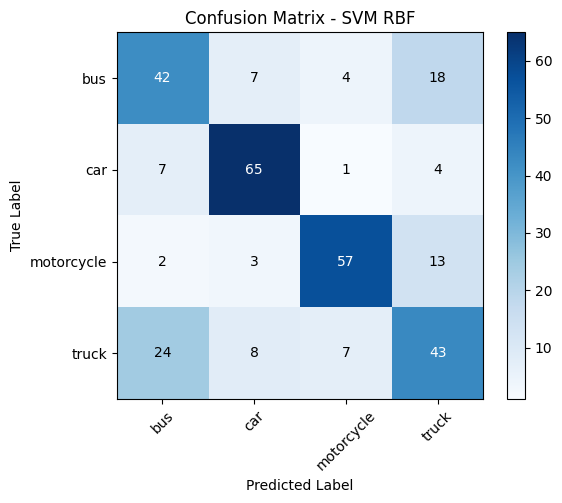


###Visualisasi Hasil Prediksi - SVM RBF###


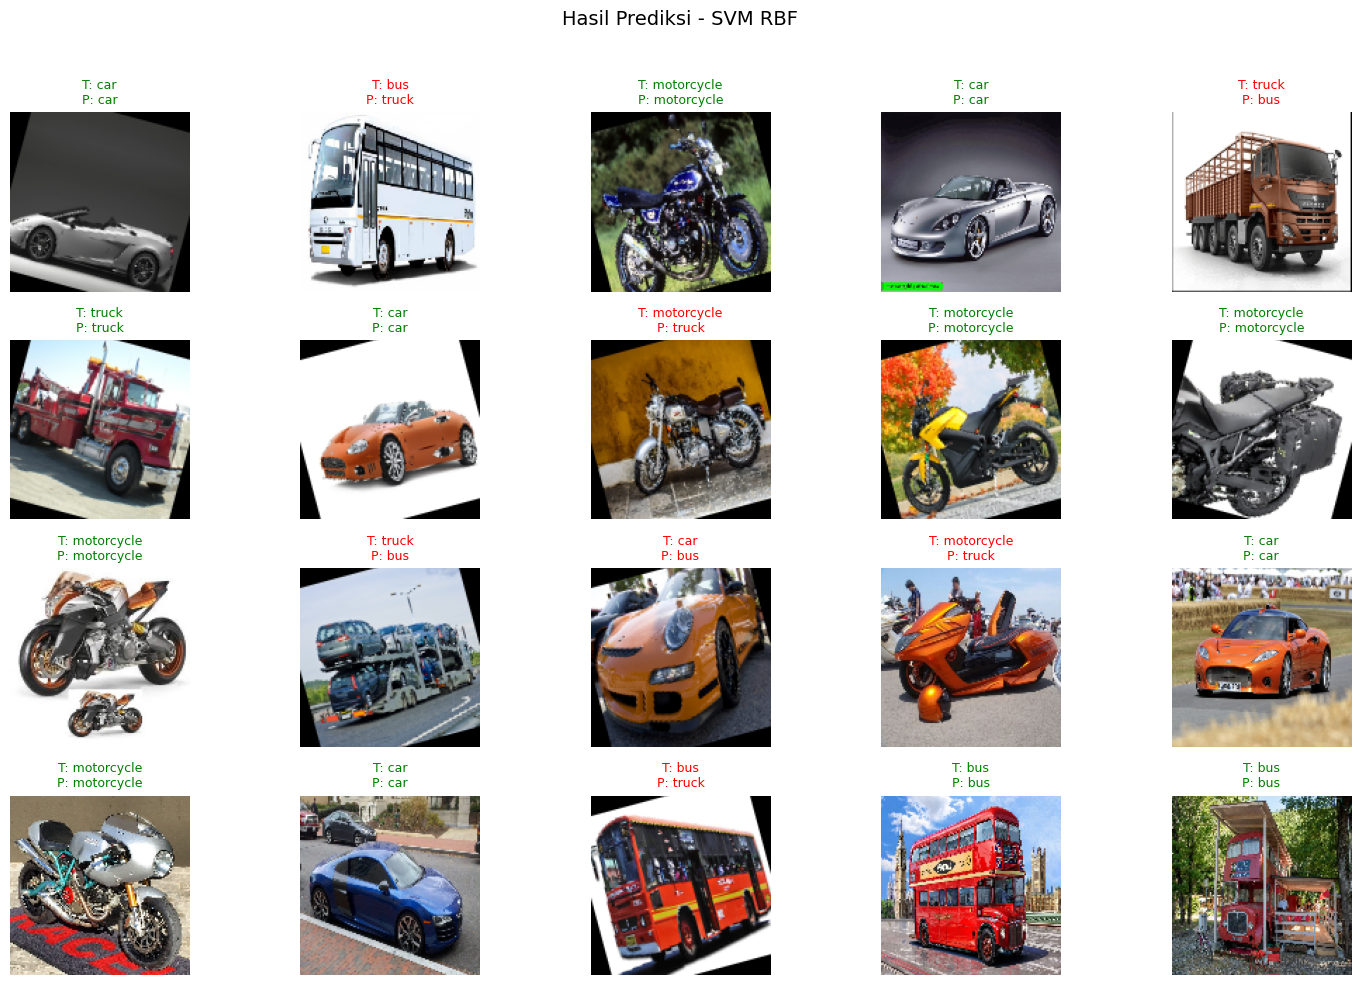

In [23]:
# evaluasi dan visualisasi prediksi model kernel RBF
evaluate(y_test, y_pred_rbf, "SVM RBF", le)
visualize_predictions(y_test, y_pred_rbf, img_test, "SVM RBF", le)

TRAIN MODEL SVM LINEAR

In [24]:
# melakukan training menggunakan model kernel Linear
print("\nMemulai training menggunakan model kernel Linear...")

param_grid_linear = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear']
}
svm_linear = GridSearchCV(SVM(), param_grid_linear, cv=3)
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)

print("\nParameter terbaik (Linear):", svm_linear.best_params_)


Memulai training menggunakan model kernel Linear...

Parameter terbaik (Linear): {'C': 0.01, 'kernel': 'linear'}


EVALUASI DAN PREDIKSI MODEL SVM LINEAR


###Classification Report - SVM Linear###
               precision    recall  f1-score   support

bus                  0.00      0.00      0.00        71
car                  0.25      1.00      0.41        77
motorcycle           0.00      0.00      0.00        75
truck                1.00      0.04      0.07        82

accuracy                                      0.26       305
macro avg            0.31      0.26      0.12       305
weighted avg         0.33      0.26      0.12       305

Accuracy Score: 0.2623


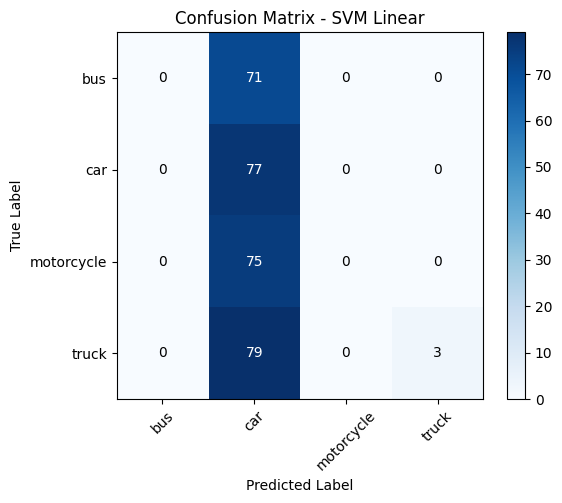


###Visualisasi Hasil Prediksi - SVM Linear###


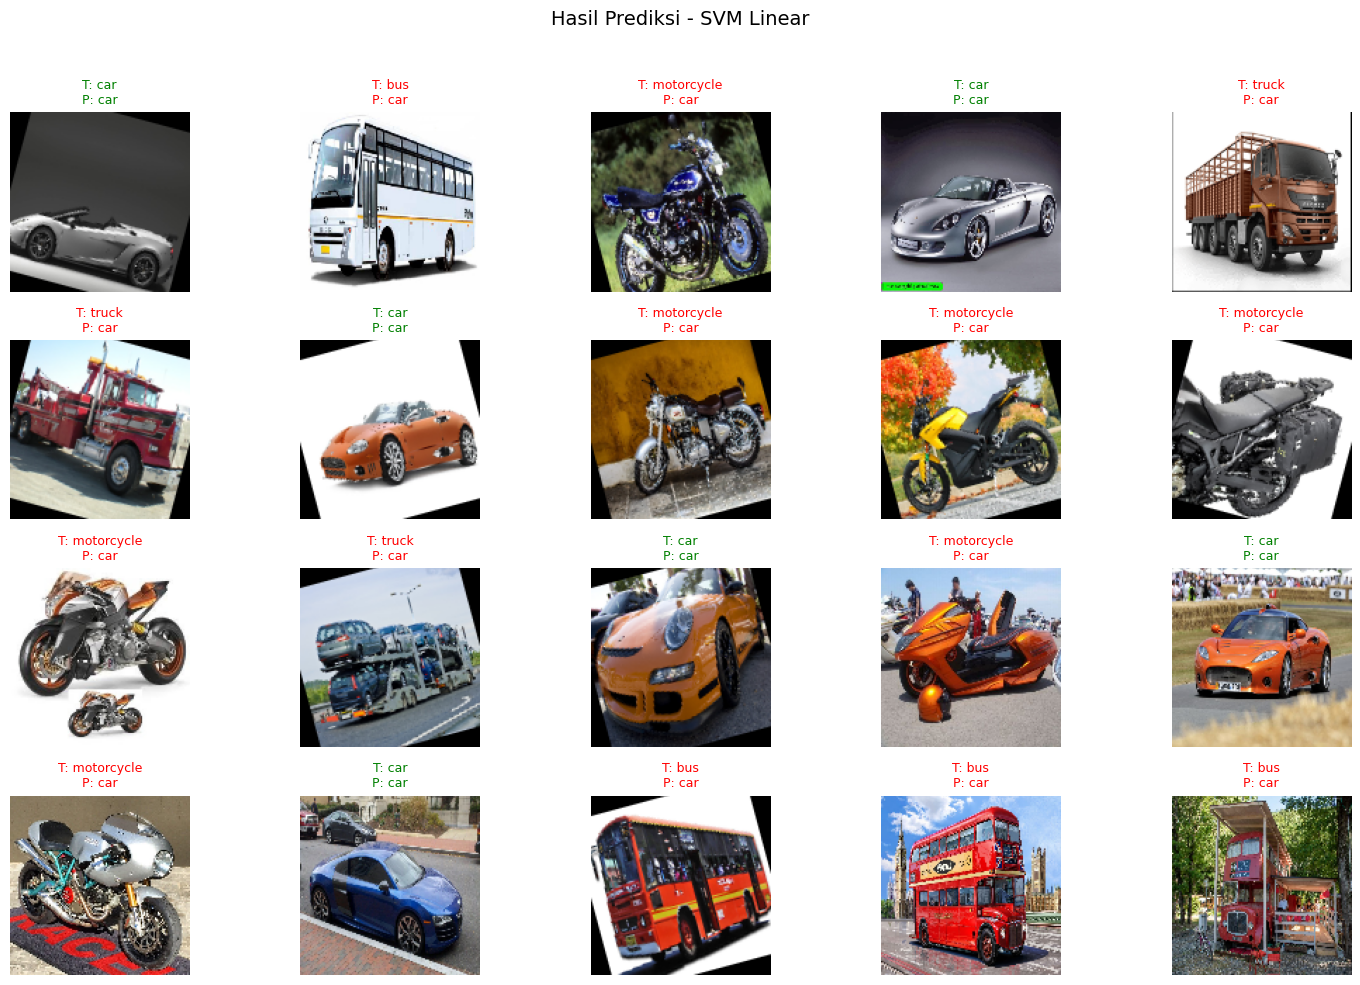

In [25]:
# evaluasi dan visualisasi prediksi model kernel Linear
evaluate(y_test, y_pred_linear, "SVM Linear", le)
visualize_predictions(y_test, y_pred_linear, img_test, "SVM Linear", le)